In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
from src.main import get_pages, calc_document_layout
from src import sweep
import utils

pdf_path = Path('/home/jtt/Documents/datasets/wormbase/pmid18430922.pdf')
full_base_path = Path('/home/jtt/Documents/outputs/tests')

# TODO: review pmid19158391 for Syntax Warning: Bad annotation destination

In [2]:
# xpdf_folder_name = f"xpdf_{pdf_path.stem}"
# xpdf_folder_path = utils.pdf2html(
#     pdf_path.resolve(), full_base_path.resolve(), xpdf_folder_name
# )

In [3]:
xpdf_folder_path = '/home/jtt/Documents/outputs/tests/samples/xpdf_pmid18430929'
# xpdf_folder_path = Path('../tests/output/pdf2')
pages = get_pages(Path(xpdf_folder_path))

In [4]:
layout = calc_document_layout(pages)
layout

Layout(width=602, height=782, num_cols=2, row_width=212, row_height=9, content_region=Bbox(x=55, y=23, width=492, height=721, x1=547, y1=744), col_coords=[55, 318])

In [5]:
from src.draw import draw_content_region, draw_text_regions, draw_columns, draw_bboxes
from src.contours import get_potential_contours
from PIL import Image

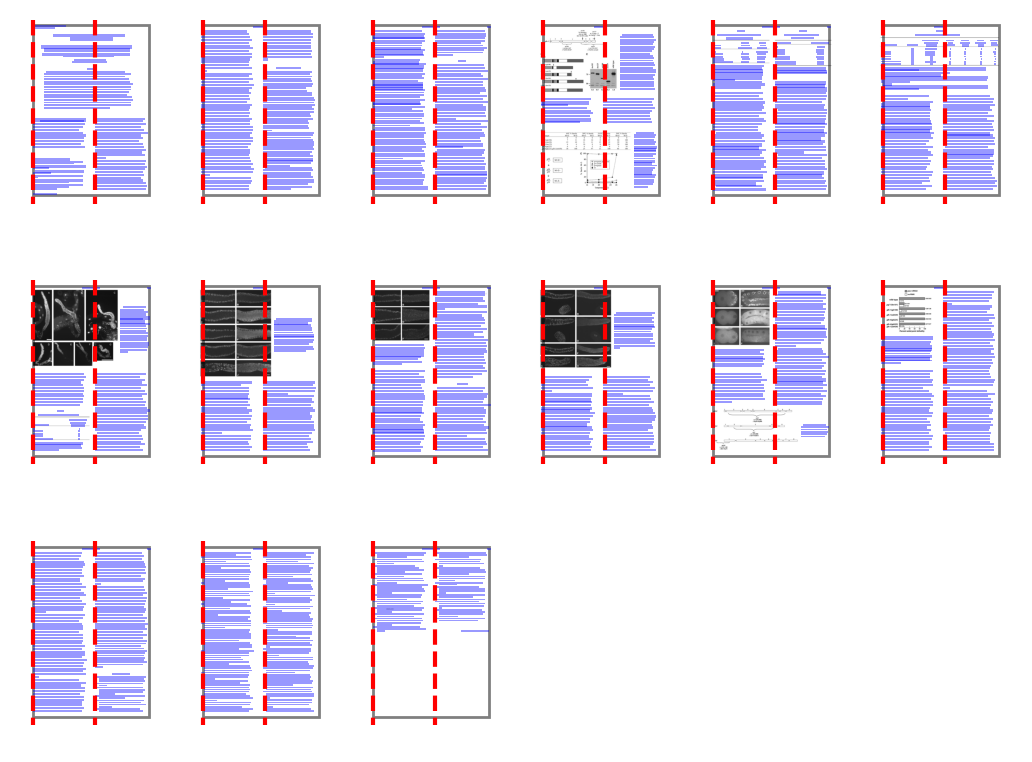

In [6]:
number_cols = 6
number_rows = int(len(pages) / number_cols) + 1
_, ax = plt.subplots(number_rows, number_cols, dpi=200)

for idx, page in enumerate(pages):
  col = idx % number_cols
  row = int(idx / number_cols) 

  page_name = page.img_name
  png_path = (Path(xpdf_folder_path) / page_name).resolve()
  page_image = Image.open(png_path)
  page_image = page_image.resize((page.width, page.height)) 

  draw_content_region(ax[row][col], layout.content_region)
  draw_text_regions(ax[row][col], page)
  draw_columns(ax[row][col], layout)
  ax[row][col].imshow(page_image)
  ax[row][col].axis('off')

for idx in range(len(pages), number_rows*number_cols):
  col = idx % number_cols
  row = int(idx / number_cols) 
  ax[row][col].axis('off')

## Try to find expand captions first

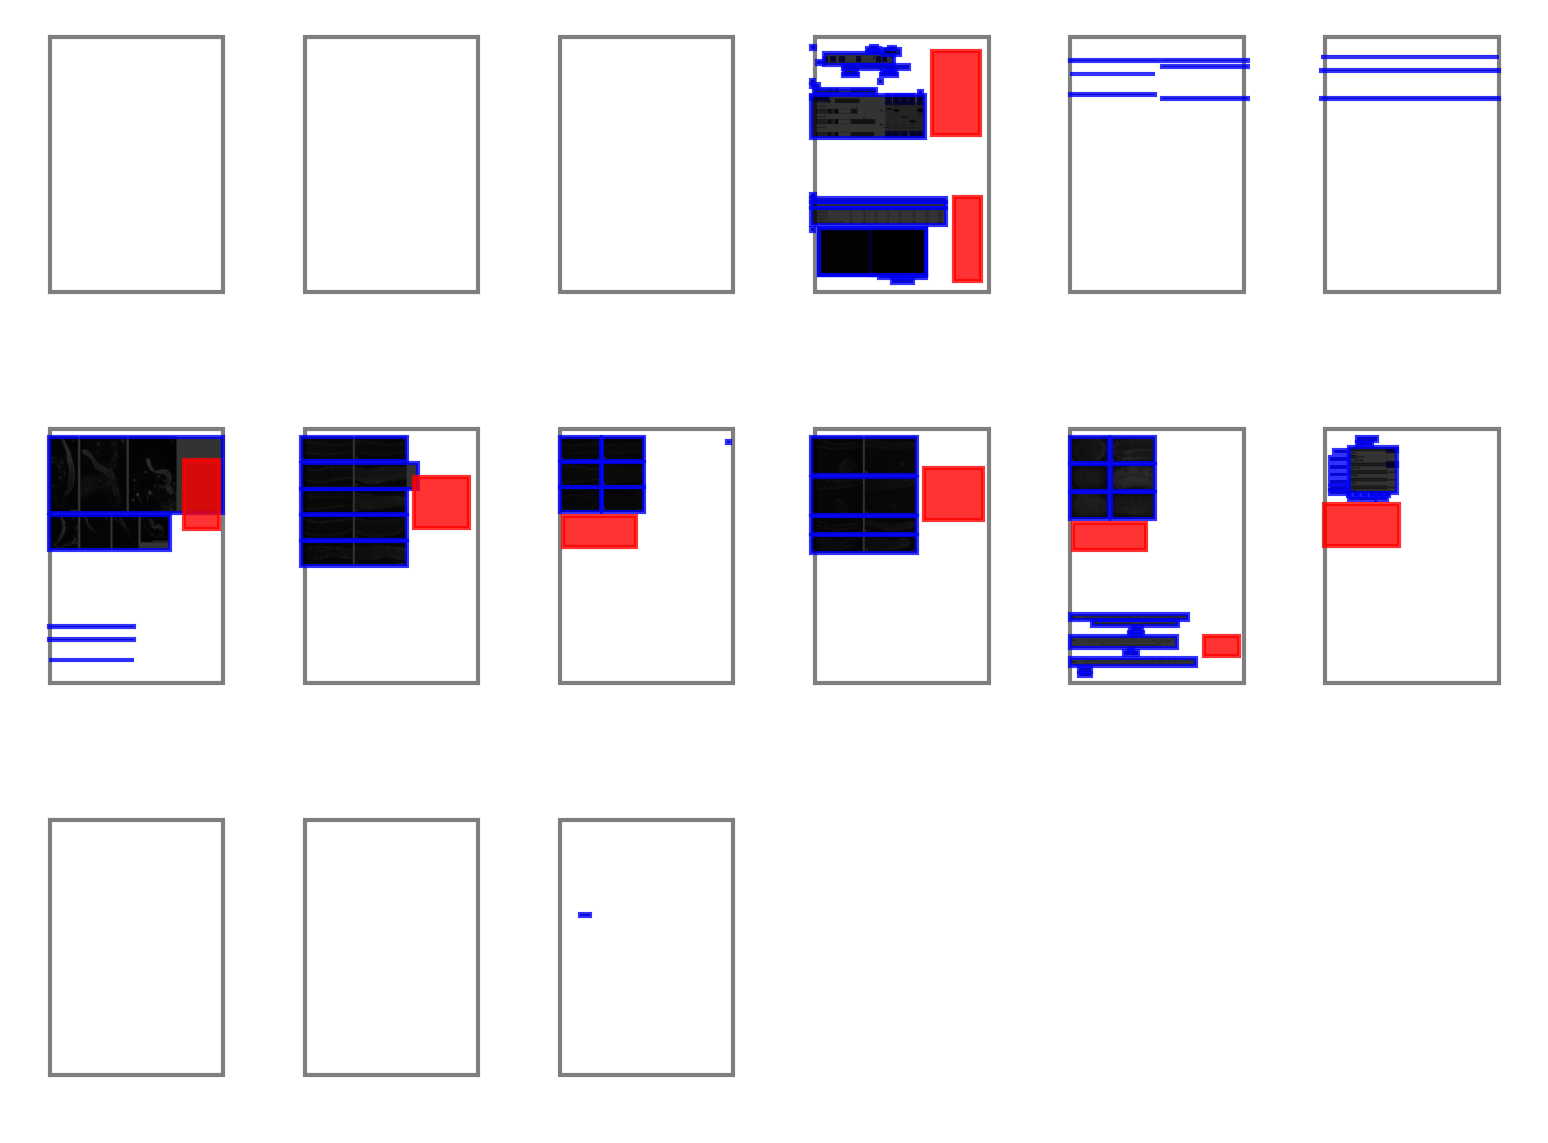

In [7]:
number_cols = 6
number_rows = int(len(pages) / number_cols) + 1
_, ax = plt.subplots(number_rows, number_cols, dpi=300)

for idx, page in enumerate(pages):
  col = idx % number_cols
  row = int(idx / number_cols) 

  page_name = page.img_name
  png_path = (Path(xpdf_folder_path) / page_name).resolve()
  page_image = Image.open(png_path)
  page_image = page_image.resize((page.width, page.height)) 

  fig_captions, table_captions = page.find_caption_boxes()
  fig_captions = [page.expand_caption(caption, layout) for caption in fig_captions]  
  candidates, cnts = get_potential_contours(xpdf_folder_path, page, layout, fig_captions)

  draw_content_region(ax[row][col], layout.content_region)
  draw_bboxes(ax[row][col], cnts, edgecolor='blue', facecolor='black', alpha=0.8)
  draw_bboxes(ax[row][col], fig_captions, edgecolor='red', facecolor='red', alpha=0.8)

  ax[row][col].imshow(page_image)
  ax[row][col].axis('off')

for idx in range(len(pages), number_rows*number_cols):
  col = idx % number_cols
  row = int(idx / number_cols) 
  ax[row][col].axis('off')

## 2. Region Detection
Use the captions for figures and tables to find potential areas in the page that
can hold a figure.

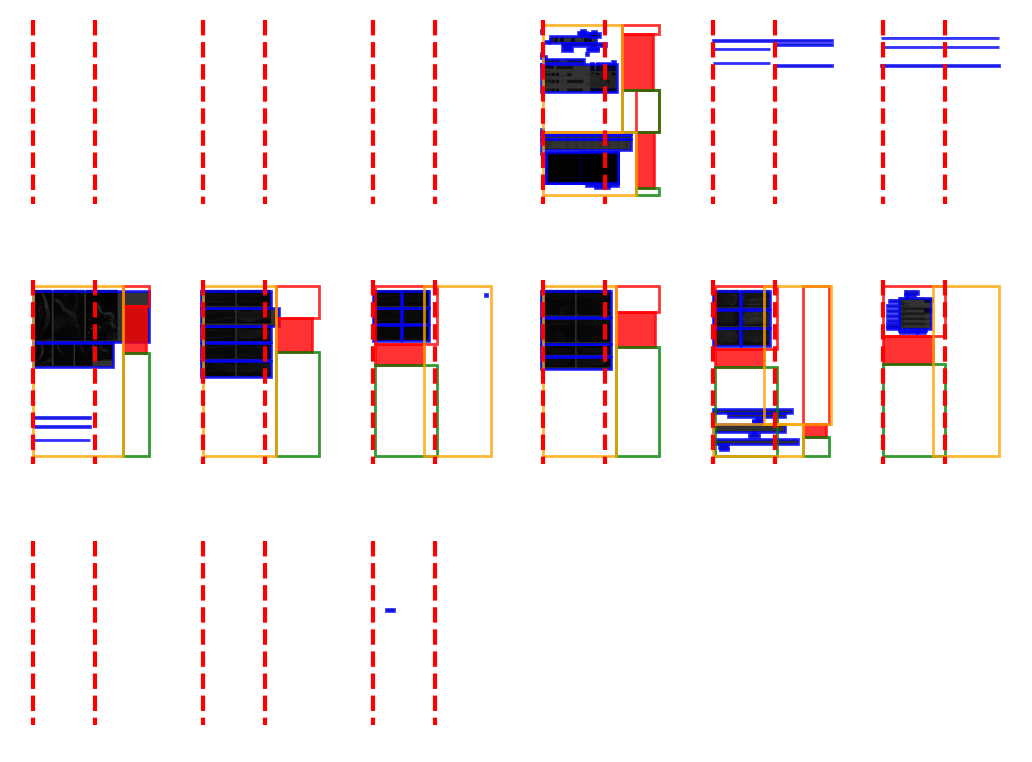

In [8]:
number_cols = 6
number_rows = int(len(pages) / number_cols) + 1
_, ax = plt.subplots(number_rows, number_cols, dpi=200)

for idx, page in enumerate(pages):
  col = idx % number_cols
  row = int(idx / number_cols) 
  page_name = page.img_name
  png_path = (Path(xpdf_folder_path) / page_name).resolve()
  page_image = Image.open(png_path)
  page_image = page_image.resize((page.width, page.height))

  fig_captions, table_captions = page.find_caption_boxes()
  fig_captions = [page.expand_caption(caption, layout) for caption in fig_captions] 

  regions_top = sweep.estimate_caption_regions_top(fig_captions, layout)
  regions_bottom = sweep.estimate_caption_regions_bottom(fig_captions, layout)
  regions_side = sweep.estimate_caption_regions_side(fig_captions, layout)

  candidates, cnts = get_potential_contours(xpdf_folder_path, page, layout, fig_captions)
  draw_bboxes(ax[row][col], cnts, edgecolor='blue', facecolor='black', alpha=0.8)
  draw_bboxes(ax[row][col], fig_captions, edgecolor='red', facecolor='red', alpha=0.8)

  top_bboxes = [el.bbox for el in regions_top]
  bottom_boxes = [el.bbox for el in regions_bottom]
  side_boxes = [el.bbox for el in regions_side]

  draw_bboxes(ax[row][col], top_bboxes, edgecolor='red', facecolor='none', alpha=0.8)
  draw_bboxes(ax[row][col], bottom_boxes, edgecolor='green', facecolor='none', alpha=0.8)
  draw_bboxes(ax[row][col], side_boxes, edgecolor='orange', facecolor='none', alpha=0.8)

  draw_columns(ax[row][col], layout)
  ax[row][col].imshow(page_image)
  ax[row][col].axis('off')

for idx in range(len(pages), number_rows*number_cols):
  col = idx % number_cols
  row = int(idx / number_cols) 
  ax[row][col].axis('off')

In [9]:
def filter_images_by_area(page, threshold=1000):
  page.figures = [f for f in page.figures if f.bbox.width * f.bbox.height > threshold]

for page in pages:
  fig_captions, table_captions = page.find_caption_boxes()
  fig_captions = [page.expand_caption(caption, layout) for caption in fig_captions] 
  candidates, _ = get_potential_contours(xpdf_folder_path, page, layout, fig_captions)
  if page.number == 11:
    print(fig_captions)
  if len(fig_captions) > 0 and len(candidates) > 0:
    sweep.sweep_regions(page, candidates, fig_captions, table_captions, layout)
sweep.match_orphans(pages, layout)

for page in pages:
  filter_images_by_area(page)


pg.4 2 19
pg.4 2 19
pg.4 2 19
pg.7 1 1
pg.8 1 5
pg.9 1 6
pg.10 1 4
[TextBox(x=64, y=290, width=206, height=77, x1=270, y1=367, page_number=11, text='Figure 7.—GFPTPGL-1 is not properly concentrated on P granules in living glh-1 mutants. Live worms containing a GFPTPGL-1 transgene were imaged by confocal microscopy. Images represent single $0.5-mm optical sections. (A and B) Wild type. (C and D) glh-1(bn103). (E and F) glh-1(bn125). The majority of GFPTPGL-1 is dispersed in the cytoplasm of glh- 1(bn103) embryos (C) and germlines (D). glh-1(bn125) worms display less dramatic dispersal of GFPTPGL-1. Bars, 10 mm.'), TextBox(x=435, y=610, width=99, height=57, x1=534, y1=667, page_number=11, text='Figure 8.—Mutant alleles of glh-2, glh-3, and glh-4. A schematic of each glh gene shows the posi- tion and extent of each deletion allele. Coding regions are shown as boxes and introns as lines.')]
pg.11 2 13
pg.11 1 7
pg.12 1 12


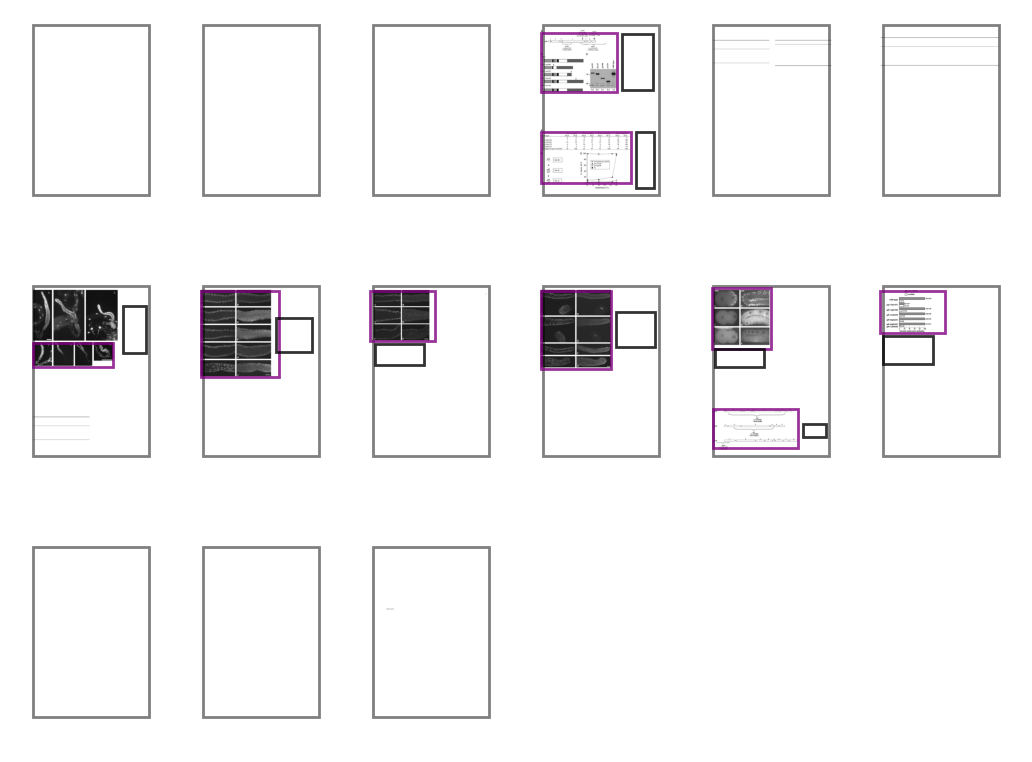

In [10]:
number_cols = 6
number_rows = int(len(pages) / number_cols) + 1
_, ax = plt.subplots(number_rows, number_cols, dpi=200)

for idx, page in enumerate(pages):
  col = idx % number_cols
  row = int(idx / number_cols) 

  page_name = page.img_name
  png_path = (Path(xpdf_folder_path) / page_name).resolve()
  page_image = Image.open(png_path)
  page_image = page_image.resize((page.width, page.height)) 

  draw_content_region(ax[row][col], layout.content_region)

  figures = [x.bbox for x in page.figures]
  captions = [x.caption for x in page.figures if x.caption is not None]
  draw_bboxes(ax[row][col], figures, 'purple', 'none', 0.8)
  draw_bboxes(ax[row][col], captions, 'black', 'none', 0.8)

  ax[row][col].imshow(page_image)
  ax[row][col].axis('off')

for idx in range(len(pages), number_rows*number_cols):
  col = idx % number_cols
  row = int(idx / number_cols) 
  ax[row][col].axis('off')

In [11]:
pages[11].figures

[Figure(bbox=Bbox(x=41.25, y=46, width=276.75, height=179, x1=318, y1=225), multicolumn=True, caption=TextBox(x=53, y=236, width=212, height=118, x1=265, y1=354, page_number=12, text='Figure 9.—glh-1 mutants and glh-4 glh-1 double mutants are not resistant to RNAi. Worms of the genotypes shown were fed bacteria expressing dsRNA against pos-1 and allowed to pro- duce embryos at 20°. The following strains and generations were used: glh-1(ok439), glh-4(gk225), and pgl-1(bn101), MÀZÀ generation; glh-1(gk100) and glh-4(gk225) glh-1(ok439), M1ZÀ generation. pgl-1 mutants were resistant to pos-1 RNAi, as re- ported by Robert et al. (2005). The other strains were sensi- tive. glh-1(gk100) MÀZÀ animals also appear to be sensitive to pos-1(RNAi) (95% lethality), but glh-1(gk100) MÀZÀ animals not exposed to pos-1 dsRNA also laid a signiﬁcant percentage of eggs that died (51%).'), sweep_type='unique_0', identifier='Figure 9.', type='temp')]

In [12]:
from src.models import Bbox
from src.utils import overlap_ratio_based

bbox1 = Bbox(0, 0, 100, 100)
bbox2 = Bbox(25, 25, 120, 10)

# how much bbox2 is in bbox2
overlap_ratio_based(bbox2, bbox1)

0.625